#### Download data:

In [1]:
!curl --create-dirs -o './data/AER_credit_card_data.csv' 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 73250  100 73250    0     0   415k      0 --:--:-- --:--:-- --:--:--  418k


#### import libs:

In [3]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

#### Preparation

In [110]:
'''
Create the target variable by mapping yes to 1 and no to 0.
Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. 
Use train_test_split funciton for that with random_state=1.
'''

df = pd.read_csv('./data/AER_credit_card_data.csv')
df.head()

df.card = df.card.map({'yes': 1, 'no':0})

df.owner = df.owner.map({'yes': 1, 'no':0})
df.selfemp = df.selfemp.map({'yes': 1, 'no':0})

df.info()

from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
print(f'Shape of \n Train: {df_train.shape[0]} \n val: {df_val.shape[0]} \n test:{df_test.shape[0]}')


df_full_train.reset_index(drop=True, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   int64  
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   int64  
 7   selfemp      1319 non-null   int64  
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int64(8)
memory usage: 123.8 KB
Shape of 
 Train: 791 
 val: 264 
 test:264


In [5]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,1,0,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,0,0,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,1,0,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,0,0,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,1,0,2,64,1,5


#### Question 1
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score and compute AUC with the card variable.
Use the training dataset for that.
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenditure'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?



In [6]:
df.columns

Index(['card', 'reports', 'age', 'income', 'share', 'expenditure', 'owner',
       'selfemp', 'dependents', 'months', 'majorcards', 'active'],
      dtype='object')

In [7]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')


columns = ['reports', 'age', 'income', 'share', 'expenditure', 'owner',
       'selfemp', 'dependents', 'months', 'majorcards', 'active']

scores = {}
for c in columns[::-1]:
    #print(f'Column: {c}')
    columns.remove(c)
    
    model = LogisticRegression()
    model.fit(df_train[columns], df_train.card)
    score = roc_auc_score(df_train.card, model.predict(df_train[columns]))
    scores[c]=score
    
    columns.append(c)
    print(f'AUC Score without {c}: {score}')
    
#'share': 0.990228013029316,

AUC Score without active: 0.989413680781759
AUC Score without majorcards: 0.990228013029316
AUC Score without months: 0.990228013029316
AUC Score without dependents: 0.9865888220246968
AUC Score without selfemp: 0.990228013029316
AUC Score without owner: 0.990228013029316
AUC Score without expenditure: 0.7262693461418135
AUC Score without share: 0.990228013029316
AUC Score without income: 0.990228013029316
AUC Score without age: 0.990228013029316
AUC Score without reports: 0.989413680781759


#### Training the model
From now on, use these columns only:

`["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]`

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

`LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`


In [8]:
from sklearn.feature_extraction import DictVectorizer

#set y
y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

#concert to dict
dv = DictVectorizer(sparse=False)
X_train_dict = df_train[columns].to_dict(orient='records')
X_train = dv.fit_transform(X_train_dict)

#train model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=1, solver='liblinear')

#### Question 2
What's the AUC of this model on the validation dataset? (round to 3 digits)


In [9]:
def predict(df, dv, model):
    X_dict = df[columns].to_dict(orient='records')
    X = dv.transform(X_dict)
    
    preds = model.predict_proba(X)[:, 1]

    return preds

y_pred_val = predict(df_val, dv, model)

round(roc_auc_score(y_val, y_pred_val), 3)

0.995

#### Question 3
Now let's compute precision and recall for our model.

Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
###### At which threshold precision and recall curves intersect?


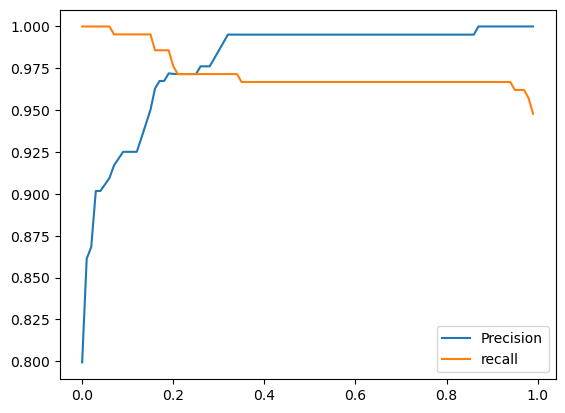

In [88]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.arange(0, 1, 0.01)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    df_scores['precision'] = df_scores['tp']/(df_scores['tp']+df_scores['fp'])    
    df_scores['recall'] = df_scores['tp']/(df_scores['tp']+df_scores['fn'])
    
    df_scores['f1_score'] = (2*df_scores['precision']*df_scores['recall'])/(df_scores['precision']+df_scores['recall'])

    return df_scores
df_scores = tpr_fpr_dataframe(y_val, y_pred_val)
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

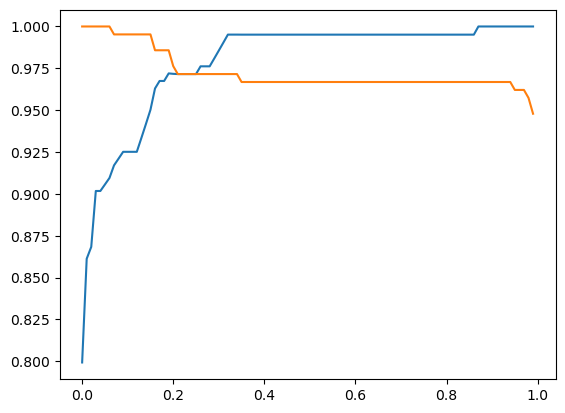

In [86]:
from sklearn.metrics import precision_score, recall_score

p_scores = []
r_scores = []
thresholds = []
for i in np.arange(0,1, 0.01):
    p_score = precision_score(y_val, (y_pred_val>i).astype(int))
    p_scores.append(p_score)
    
    r_score = recall_score(y_val, (y_pred_val>i).astype(int))
    r_scores.append(r_score)
    thresholds.append(i)

plt.plot(thresholds, p_scores)
plt.plot(thresholds, r_scores)

#### Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing :
```
F1 = 2 * Precision * Recall
    -------------------------
        Precision + Recall
````


Where  is precision and  is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

###### At which threshold F1 is maximal?

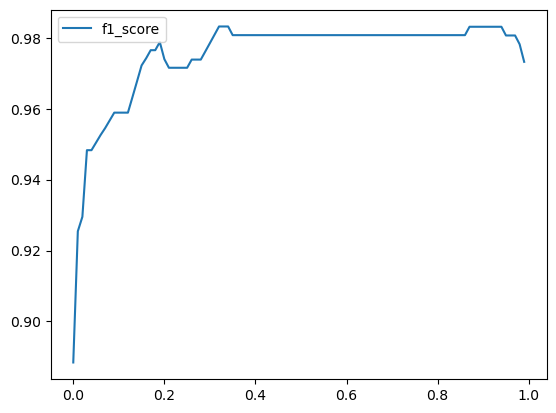

In [89]:
plt.plot(df_scores.threshold, df_scores['f1_score'], label='f1_score')
plt.legend()

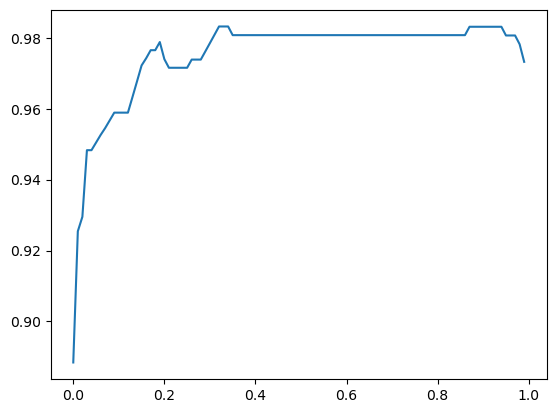

In [97]:
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = []
p_scores = []
r_scores = []
f1_scores = []

for i in np.arange(0, 1, 0.01):
    p_score = precision_score(y_val, (y_pred_val>i).astype(int))
    p_scores.append(p_score)
    
    r_score = recall_score(y_val, (y_pred_val>i).astype(int))
    r_scores.append(r_score)
    thresholds.append(i)
    
    f1_s = f1_score(y_val, (y_pred_val>i).astype(int))
    f1_scores.append(f1_s)

df_scores_sk = pd.DataFrame()
df_scores_sk['thresholds'] = thresholds
df_scores_sk['p_scores'] = p_scores
df_scores_sk['r_scores'] = r_scores
df_scores_sk['f1_scores'] = f1_scores


plt.plot(thresholds, df_scores_sk['f1_scores'])


### Question 5
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* Use AUC to evaluate the model on validation
#### How large is standard devidation of the AUC scores across different folds?

In [120]:
from sklearn.model_selection import KFold



for C in [0.01, 0.1, 1, 10]:

    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []
    
    for train_idx, val_idx in kf.split(df_full_train[columns]):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv = DictVectorizer(sparse=False)
        X_train_dict = df_train[columns].to_dict(orient='records')
        X_train = dv.fit_transform(X_train_dict)

        X_val_dict = df_val.to_dict(orient='records')
        X_val = dv.transform(X_val_dict)
        
        
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        y_pred_val = predict(df_val, dv, model)
        
        score = roc_auc_score(y_val, y_pred_val)
        scores.append(score)
    
    print(f'C={C} -- {np.mean(scores).round(3)} +- {np.std(scores).round(3)}')
        


C=0.01 -- 0.992 +- 0.006
C=0.1 -- 0.994 +- 0.005
C=1 -- 0.996 +- 0.003
C=10 -- 0.997 +- 0.003


### Question 6
Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.01, 0.1, 1, 10]
Initialize KFold with the same parameters as previously
Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

#### Which C leads to the best mean score?

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

**Answer is 10**

Grabbed from previsious cell